Загрузка библиотек и данных:

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import jaccard_score
from scipy.sparse import csr_matrix

data = np.load('morgan_fp.npz')
fp_smiles = pd.read_csv('fp_smiles.csv')
for name in data.files:
    print(f"Массив: {name}")
    print(data[name])
    print("---")

Массив: indices
[  13   80  147 ... 1873 1954 1970]
---
Массив: indptr
[       0       19       34 ... 15295966 15296019 15296075]
---
Массив: format
np.bytes_(b'csr')
---
Массив: shape
[339061   2048]
---
Массив: data
[1 1 1 ... 1 1 1]
---


Восстановление матрицы из сжатого формата, преобразование её в датафрейм и объединение с БД smiles:

In [2]:
sparse_matrix = csr_matrix(
    (data['data'], data['indices'], data['indptr']),
    shape=tuple(data['shape'])
)

print(f"Размерность матрицы: {sparse_matrix.shape}")
print(f"Количество ненулевых элементов: {sparse_matrix.nnz}")

Размерность матрицы: (339061, 2048)
Количество ненулевых элементов: 15296075


In [3]:
matrix_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)
combined_df = pd.concat([fp_smiles, matrix_df], axis=1)

In [4]:
display(combined_df)

,index,smiles,0,1,2,3,4,5,6,7,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,CC(=O)OCC[N+](C)(C)C,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,C[N+](C)(C)CC(=O)[O-],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,O=C(NC(CO)C(O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,O=C(O)c1ccccc1O,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339056,339056,N#Cc1ccc(Cn2cncc2C[NH2+]C2CCN(c3cccc4ncccc34)C...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
339057,339057,N#Cc1ccc(Cn2cncc2C[NH2+]C2CCN(c3ccncc3)C2=O)cc1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
339058,339058,N#Cc1ccc(Cn2cncc2C[NH2+]C2CCN(Cc3cccc(Cl)c3)C2...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
339059,339059,N#Cc1ccc(Cn2cncc2C[NH2+]C2CCN(Cc3ccccc3)C2=O)cc1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(f"Размер: {sparse_matrix.shape}")
print(f"Заполненность: {sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]):.4f}")
print(f"Ненулевых элементов: {sparse_matrix.nnz}")
non_zero_per_row = np.diff(sparse_matrix.indptr)
print(f"Среднее ненулевых в строке: {non_zero_per_row.mean():.1f}")

Размер: (339061, 2048)
Заполненность: 0.0220
Ненулевых элементов: 15296075
Среднее ненулевых в строке: 45.1


Разреженность: 0.9780


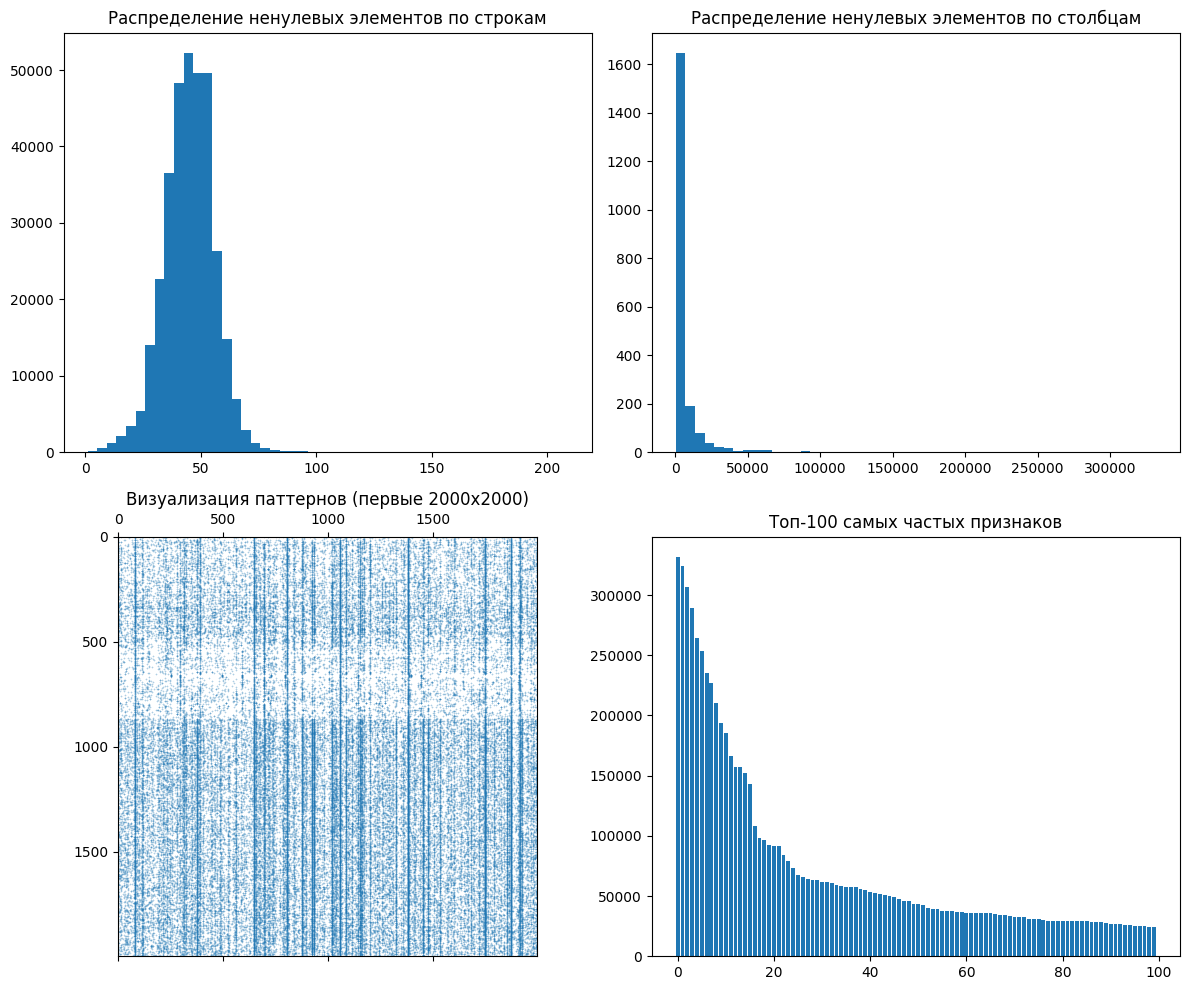

In [6]:
sparsity = 1 - (sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]))
print(f"Разреженность: {sparsity:.4f}")

row_nonzeros = np.diff(sparse_matrix.indptr)
col_nonzeros = np.bincount(sparse_matrix.indices)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].hist(row_nonzeros, bins=50)
axes[0,0].set_title('Распределение ненулевых элементов по строкам')

axes[0,1].hist(col_nonzeros, bins=50)
axes[0,1].set_title('Распределение ненулевых элементов по столбцам')

axes[1,0].spy(sparse_matrix[:2000, :2000], markersize=0.1)
axes[1,0].set_title('Визуализация паттернов (первые 2000x2000)')

axes[1,1].bar(range(100), sorted(col_nonzeros, reverse=True)[:100])
axes[1,1].set_title('Топ-100 самых частых признаков')

plt.tight_layout()
plt.show()

dense_small = sparse_matrix[:, np.argsort(col_nonzeros)[-100:]].toarray()  # топ-100 признаков
correlation_matrix = np.corrcoef(dense_small.T)

Первичный EDA:

Основные характеристики:
 - Размер матрицы: (339 061 × 2 048)
   - 339 061 соединение × 2 048 признаков
 - Заполненность: 0.0220 (~2.2 % элементов ненулевые, матрица очень разрежённая)
 - Количество ненулевых элементов: 15 296 075
 - Среднее ненулевых в строке: ~45 (в среднем у каждого соединения активно около 45 признаков из 2048, что немного, но достаточно для различимости)

Анализ графиков:
1. Распределение ненулевых элементов по строкам
 - Гистограмма показывает колоколоподобное распределение с центром около 45 ненулевых значений.
 - Практически все строки имеют 20–80 активных признаков.
 - Аномалий (соединений с необычно большим или маленьким количеством признаков) почти нет.

2. Распределение ненулевых элементов по столбцам
 - Распределение сильно скошено вправо.
 - Большинство признаков встречаются редко, но есть несколько особо частых признаков.

3. Визуализация паттернов
 - Визуализация первых 2000×2000 элементов показывает «снежный» паттерн: равномерное, но редкое распределение точек.
 - Видны вертикальные полосы — признаки, активные у большого числа соединений.
 - Это согласуется с предыдущим графиком — некоторые признаки встречаются почти у всех образцов.

4. Топ-100 самых частых признаков
 - Верхние признаки встречаются большинства соединений (не дискриминируют токсичные и нетоксичные вещества, так как они слишком общие)

Выводы:
 - Распределение по строкам — равномерное.
 - Распределение по столбцам — крайне неравномерное, есть признаки с чрезмерной частотой => стоит провести отбор признаков.
 - Редкие признаки (встречающиеся в <0.01 % случаев) тоже могут быть удалены как шум.

Удаляем слишком частые и слишком редкие признаки:


Статистика признаков до фильтрации:
           feature          count    frequency
count  2048.000000    2048.000000  2048.000000
mean   1023.500000    7468.786621     0.022028
std     591.350996   22444.323378     0.066196
min       0.000000     374.000000     0.001103
1%       20.470000     579.290000     0.001709
5%      102.350000     806.700000     0.002379
50%    1023.500000    2591.500000     0.007643
95%    1944.650000   23588.200000     0.069569
99%    2026.530000   91624.090000     0.270229
max    2047.000000  331746.000000     0.978426

После частотной фильтрации: 2045 из 2048 признаков

Датасет до фильтрации:
 - Размер: (339061, 2048)
 - Ненулевых элементов: 15,296,075
 - Среднее ненулевых в строке: 45.11
 - Разрежённость: 0.9780

После фильтрации:
 - Размер: (339061, 2045)
 - Ненулевых элементов: 14,334,123
 - Среднее ненулевых в строке: 42.28
 - Разрежённость: 0.9793


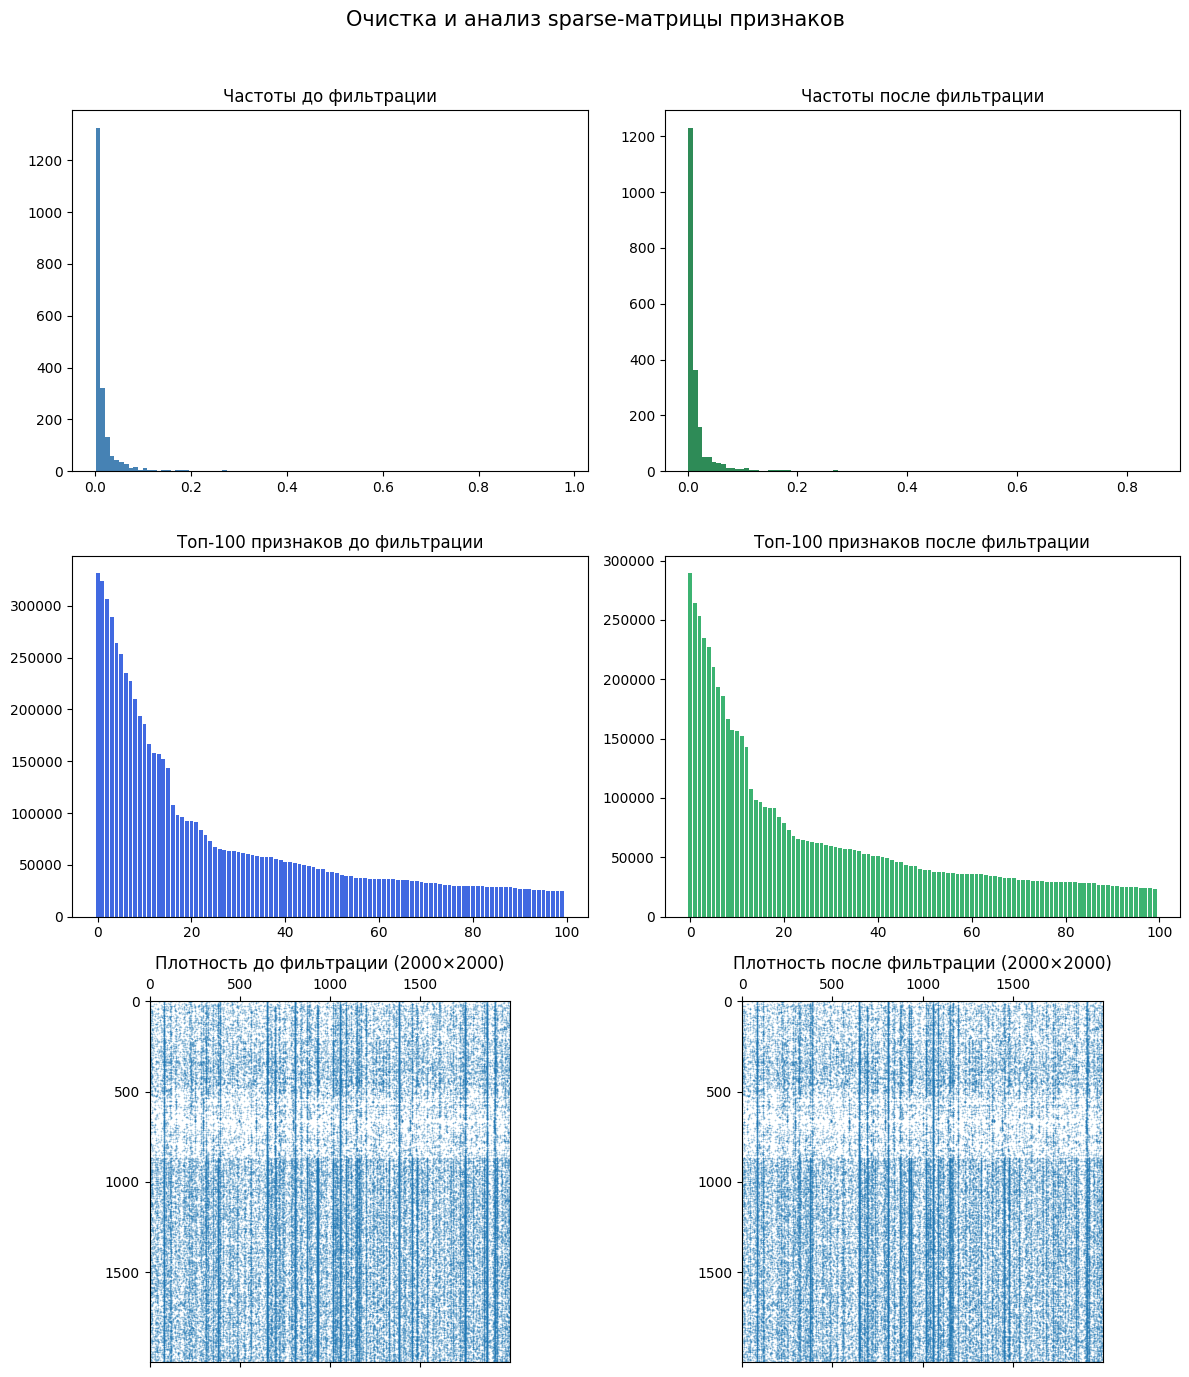


Удалено 0 коррелированных признаков (|r|>0.95)


In [8]:
# Базовая статистика
feature_counts = np.array((sparse_matrix != 0).sum(axis=0)).flatten()
n_samples = sparse_matrix.shape[0]

feature_stats = pd.DataFrame({
    'feature': np.arange(sparse_matrix.shape[1]),
    'count': feature_counts,
    'frequency': feature_counts / n_samples
})

print("\nСтатистика признаков до фильтрации:")
print(feature_stats.describe(percentiles=[0.01, 0.05, 0.95, 0.99]))

# Фильтрация по частоте
min_freq = 0.001
max_freq = 0.90

mask = (feature_stats['frequency'] >= min_freq) & (feature_stats['frequency'] <= max_freq)
selected_features = feature_stats.loc[mask, 'feature'].values
filtered_stats = feature_stats[mask]

print(f"\nПосле частотной фильтрации: {len(selected_features)} из {sparse_matrix.shape[1]} признаков")

sparse_matrix_filtered = sparse_matrix[:, selected_features]

# Метрики плотности
def get_sparsity_info(matrix, name="Матрица"):
    total_elements = matrix.shape[0] * matrix.shape[1]
    nonzero_elements = matrix.count_nonzero()
    sparsity = 1 - (nonzero_elements / total_elements)
    avg_nonzeros_per_row = nonzero_elements / matrix.shape[0]
    print(f"\n{name}:")
    print(f" - Размер: {matrix.shape}")
    print(f" - Ненулевых элементов: {nonzero_elements:,}")
    print(f" - Среднее ненулевых в строке: {avg_nonzeros_per_row:.2f}")
    print(f" - Разрежённость: {sparsity:.4f}")
    return sparsity, avg_nonzeros_per_row

sparsity_before, avg_before = get_sparsity_info(sparse_matrix, "Датасет до фильтрации")
sparsity_after, avg_after = get_sparsity_info(sparse_matrix_filtered, "После фильтрации")

# Визуализация плотности и распределений
fig, axes = plt.subplots(3, 2, figsize=(12, 14))
fig.suptitle("Очистка и анализ sparse-матрицы признаков", fontsize=15)

axes[0, 0].hist(feature_stats['frequency'], bins=100, color='steelblue')
axes[0, 0].set_title("Частоты до фильтрации")
axes[0, 1].hist(filtered_stats['frequency'], bins=100, color='seagreen')
axes[0, 1].set_title("Частоты после фильтрации")

top_before = feature_stats.sort_values('count', ascending=False).head(100)
axes[1, 0].bar(range(100), top_before['count'], color='royalblue')
axes[1, 0].set_title("Топ-100 признаков до фильтрации")
top_after = filtered_stats.sort_values('count', ascending=False).head(100)
axes[1, 1].bar(range(100), top_after['count'], color='mediumseagreen')
axes[1, 1].set_title("Топ-100 признаков после фильтрации")

sample_size = min(2000, sparse_matrix.shape[0])
axes[2, 0].spy(sparse_matrix[:sample_size, :2000], markersize=0.1)
axes[2, 0].set_title("Плотность до фильтрации (2000×2000)")
axes[2, 1].spy(sparse_matrix_filtered[:sample_size, :2000], markersize=0.1)
axes[2, 1].set_title("Плотность после фильтрации (2000×2000)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Корреляционный анализ (по выборке)
sample_n = min(5000, sparse_matrix_filtered.shape[0])
dense_sample = sparse_matrix_filtered[:sample_n].toarray()

corr_matrix = np.corrcoef(dense_sample, rowvar=False)
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr = np.abs(corr_matrix) > 0.95
high_corr = np.where(upper & high_corr)
to_drop_corr = np.unique(high_corr[1])

print(f"\nУдалено {len(to_drop_corr)} коррелированных признаков (|r|>0.95)")
remaining_idx = np.setdiff1d(np.arange(sparse_matrix_filtered.shape[1]), to_drop_corr)
sparse_matrix_nocorr = sparse_matrix_filtered[:, remaining_idx]

Повторный анализ после дополнительных манипуляций

Фильтрация по частоте:
- После фильтрации удалено всего 3 признака (2045/2048 осталось).
- Среднее число ненулевых в строке уменьшилось с 45.11 до 42.28
- Разрежённость немного увеличилась (0.978 до 0.9793)

Вывод:
- Почти все признаки входят в диапазон частоты 0.1-90%
- Фильтрация по частоте не сильно изменила матрицу, но слегка убрала очень редкие/частые признаки.

Корреляционный анализ:
- Количество коррелированных признаков (|r|>0.95): 0
- Признаки почти не коррелируют линейно (почти все дескрипторы вносят уникальную информацию для соединений)

Итоговые наблюдения:
- Данные разреженные, большинство признаков встречаются редко.
- Почти нет коррелированных признаков.
- Финальная матрица готова к обучению: разрежённая, уникальные дескрипторы, минимальная избыточность.